In [1]:
import main

In [2]:
import numpy as np
import time

In [3]:
precursor_1 = main.precursor_FDM(delay_group_num=1)
precursor_1.set_beta([0.0075])
precursor_1.set_lambda([0.08])

In [4]:
material_1 = main.material_FDM(mat_id=0)
material_1.set_XS('XS_scatter',[[0,0.01],[0,0]])
material_1.set_XS('Diffusion_coef',[1.4,0.4])
material_1.set_XS('XS_absorption',[0.01,0.15])
# material_1.set_XS('XS_absorption',[0.01,0.10392197])
material_1.set_XS('XS_nu_fission',[0.007,0.2])
material_1.set_XS('XS_fission_spectrum',[1.0,0.0])

In [5]:
material_2 = main.material_FDM(mat_id=1)
material_2.set_XS('XS_scatter',[[0,0.01],[0,0]])
material_2.set_XS('Diffusion_coef',[1.4,0.4])
material_2.set_XS('XS_absorption',[0.01,0.15])
# material_2.set_XS('XS_absorption',[0.02,0.15])
material_2.set_XS('XS_nu_fission',[0.007,0.2])
material_2.set_XS('XS_fission_spectrum',[1.0,0.0])

In [6]:
material_3 = main.material_FDM(mat_id=2)
material_3.set_XS('XS_scatter',[[0,0.01],[0,0]])
material_3.set_XS('Diffusion_coef',[1.3,0.5])
material_3.set_XS('XS_absorption',[0.008,0.05])
# material_3.set_XS('XS_absorption',[0.018,0.05])
material_3.set_XS('XS_nu_fission',[0.003,0.06])
material_3.set_XS('XS_fission_spectrum',[1.0,0.0])

In [7]:
geo = main.geometry_FDM(x_block=3,y_block=3)
sl = slice(0, 3, None)
geo.set_block_mat(material_3,sl,sl)
geo.set_block_mat(material_1,1,1)
geo.set_block_mat(material_2,1,0)
geo.set_block_mat(material_2,0,1)

geo.set_block_size(x_size=[24,32,24],y_size=[24,32,24])
geo.set_discretized_num(x_dim=[24,32,24],y_dim=[24,32,24])
# geo.set_discretized_num(x_dim=[48,64,48],y_dim=[48,64,48])
geo.check_blocks()

Material layout:
[[2 1 2]
 [1 0 2]
 [2 2 2]]
Block size:
x:[24, 32, 24]
y:[24, 32, 24]
Discretization number:
x:[24, 32, 24]
y:[24, 32, 24]


In [8]:
case = main.solver_FDM(folder_name='TWIGL_Seed_Blanket_2D_SCM_A1_adaptive',group_num=2)
case.add_material([material_1,material_2,material_3])
case.set_geometry(geo,transient_mode=True)
case.set_precursor(precursor_1)
case.set_neutron_velocity([1e7,2e5])

In [9]:
# Key time steps
fix_time_steps = np.array([0.0,0.2,0.4,0.5]) 
time_index = 0
time_step = fix_time_steps[0]
# Max and min time steps
max_time_step = 1e-1
min_time_step = 1e-3
# Error tolerance for adaptive time stepping
error_tolerance = 1e-3
# Time pointer
key_time_pointer = 1
# Begin calculation
while True:
    if time_index==0:
        # To get initial flux distribution
        case.solve_source_iter_correct(max_iter=50,k_tolerance=1e-5,flux_tolerance=1e-4,initial_k=1.0)
        case.solve_source_adjoint_iter_correct(max_iter=50,k_tolerance=1e-5,flux_tolerance=1e-4,initial_k=1.0)
        # case.initial_dynamics(transient_algorithm='Implicit_Euler',vtk_save=False)
        time_start=time.time()
        # case.initial_dynamics(time_steps=time_steps,transient_algorithm='SCM',vtk_save=False)
        case.initial_dynamics(time_steps=fix_time_steps,transient_algorithm='SCM_adaptive',vtk_save=False,max_time_step=max_time_step,min_time_step=min_time_step)
    else:
        # Update material
        if time_step <=0.2:
            m1_a2 = 0.15*(1-0.11667*time_step) # Linear 
        else:
            m1_a2 = 0.15*0.97666 # Jump
        material_1.set_XS('XS_absorption',[0.01,m1_a2])
        case.update_material(0,material_1,mat_type='real')
        # Get adaptive time interval 
        time_interval = case.evaluate_adaptive_time_step(time_index,pre_time_interval=time_interval,error_tolerance=error_tolerance)
        time_step = time_step_last+time_interval
        # Move the time pointer to the next key time step
        if time_step>=fix_time_steps[key_time_pointer]:
            key_time_pointer+=1
        
        print('Time={} (s)'.format(time_step))
        # Re-update material with new time step
        if time_step <=0.2:
            m1_a2 = 0.15*(1-0.11667*time_step) # Linear 
        else:
            m1_a2 = 0.15*0.97666 # Jump
        material_1.set_XS('XS_absorption',[0.01,m1_a2])
        case.update_material(0,material_1,mat_type='real')  
        # SCM solver
        case.solve_transient_SCM_PKE_predictor(time_index,time_interval,max_iter=100,k_tolerance=1e-6,flux_tolerance=1e-4,k_outer_tolerance=1e-6) # SCM with PKE predictor

    # TODO
    time_index += 1
    time_step_last = time_step
    # End or not
    if time_step_last>=fix_time_steps[-1]:
        break
    # Pre-choose the last time step
    if fix_time_steps[key_time_pointer]-time_step_last>=max_time_step:
        time_step += max_time_step 
        time_interval = max_time_step
    else:
        time_step = fix_time_steps[key_time_pointer]
        time_interval = fix_time_steps[key_time_pointer]-time_step_last
        
time_end=time.time()
print('totally cost:',time_end-time_start)

D:\Users\85136\anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
####################################
Timestep 0 calculation begins
Iteration 1: Eigenvalue k = 0.8446669513193322
Iteration 2: Eigenvalue k = 0.8899489163397002
Iteration 3: Eigenvalue k = 0.8994594776166441
Iteration 4: Eigenvalue k = 0.9038026479314235
Iteration 5: Eigenvalue k = 0.9064220494043876
Iteration 6: Eigenvalue k = 0.9081900679307713
Iteration 7: Eigenvalue k = 0.9094479494340285
Iteration 8: Eigenvalue k = 0.9103687896329571
Iteration 9: Eigenvalue k = 0.9110545506517275
Iteration 10: Eigenvalue k = 0.9115708863732314
Iteration 11: Eigenvalue k = 0.9119625156101641
Iteration 12: Eigenvalue k = 0.9122610517725338
Iteration 13: Eigenvalue k = 0.9124894190761463
Iteration 14: Eigenvalue k = 0.9126645386803547
Iteration 15: Eigenvalue k = 0.9127990586739625
Iteration 1

In [10]:
results = np.load('TWIGL_Seed_Blanket_2D_SCM_A1_adaptive/transient_results.npy',allow_pickle=True).item()

In [11]:
t = results['Time steps']
Q = results['Relative power']

In [12]:
import matplotlib.pyplot as plt

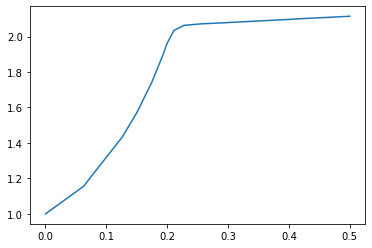

In [13]:
plt.plot(t,Q)

Text(0.5, 0, 'Time(s)')

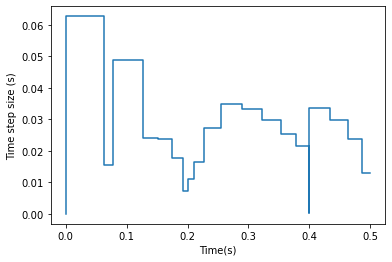

In [14]:
N_steps = len(t)
dt = np.zeros(N_steps)
dt[1:N_steps] = t[1:N_steps]-t[0:(N_steps-1)]
plt.step(t,dt)
plt.ylabel('Time step size (s)')
plt.xlabel('Time(s)')

In [15]:
Q

array([1.        , 1.15554418, 1.22410482, 1.43681153, 1.57792153,
       1.74330887, 1.89318267, 1.96251951, 2.03439441, 2.06295553,
       2.07148358, 2.07705759, 2.08301263, 2.08825401, 2.09272333,
       2.09657369, 2.09664662, 2.10320998, 2.10787316, 2.11217487,
       2.11447702])

In [16]:
t

array([0.        , 0.06275097, 0.07825232, 0.12698245, 0.1512284 ,
       0.17489183, 0.19268489, 0.2       , 0.21112089, 0.22755188,
       0.2548918 , 0.28973653, 0.32296979, 0.3527532 , 0.37796837,
       0.39967001, 0.4       , 0.43357242, 0.46330312, 0.48699705,
       0.5       ])